In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import VimeoVideo
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline
warnings.filterwarnings('ignore')

In [114]:
df = pd.read_csv('preprocessed_data.csv')
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,winter,2011,1,0,No,Saturday,No,clear,0.24,0.2879,81.0,0.0,3,13,16
1,2011-01-01,winter,2011,1,1,No,Saturday,No,clear,0.22,0.2727,80.0,0.0,8,32,40
2,2011-01-01,winter,2011,1,2,No,Saturday,No,clear,0.22,0.2727,80.0,0.0,5,27,32
3,2011-01-01,winter,2011,1,3,No,Saturday,No,clear,0.24,0.2879,75.0,0.0,3,10,13
4,2011-01-01,winter,2011,1,4,No,Saturday,No,clear,0.24,0.2879,75.0,0.0,0,1,1


- Splitting the data into `features` and `timestamp`.

- Defining a function to plot the Rolling Mean and Rolling Standard Deviation with the Augmented Dickey-Fuller stationarity test

In [115]:
"""
define function for plotting rolling statistics and ADF test for time 
series
"""
from statsmodels.tsa.stattools import adfuller
def test_stationarity(ts, window=10, **kwargs):
# create dataframe for plotting
    plot_data = pd.DataFrame(ts)
    plot_data['rolling_mean'] = ts.rolling(window).mean()
    plot_data['rolling_std'] = ts.rolling(window).std()
    # compute p-value of Dickey-Fuller test
    p_val = adfuller(ts)[1]
    ax = plot_data.plot(**kwargs)
    ax.set_title(f"Dickey-Fuller p-value: {p_val:.3f}")
    plt.show();

In [116]:
# get daily rides
daily_rides = df[["dteday", "registered", "casual"]]
daily_rides = daily_rides.groupby("dteday").sum()

# convert index to DateTime object
daily_rides.index = pd.to_datetime(daily_rides.index)

- The Dickey-Fuller Test tells that the data is not Stationary as the P-value is ``[0.355, 0.372]``.
- This is strong 
evidence that the time series is not stationary, and we need to process them in order 
to obtain a stationary one.

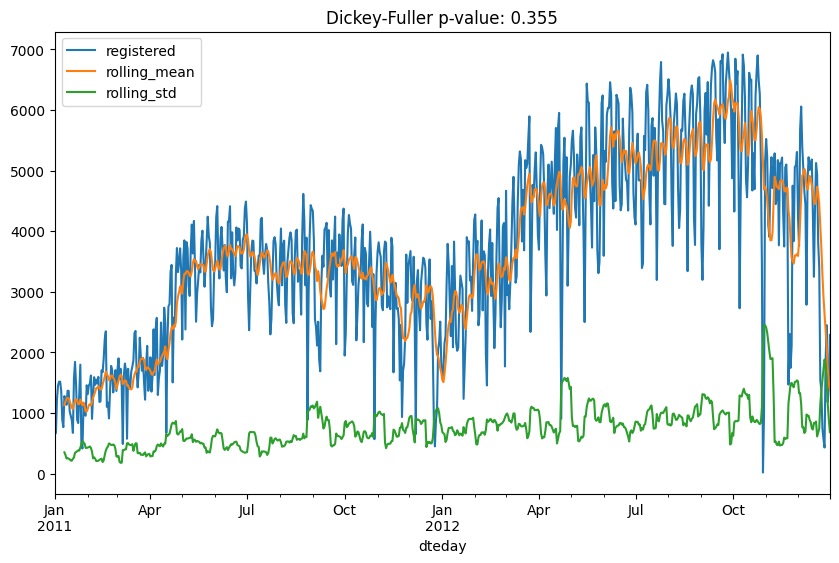

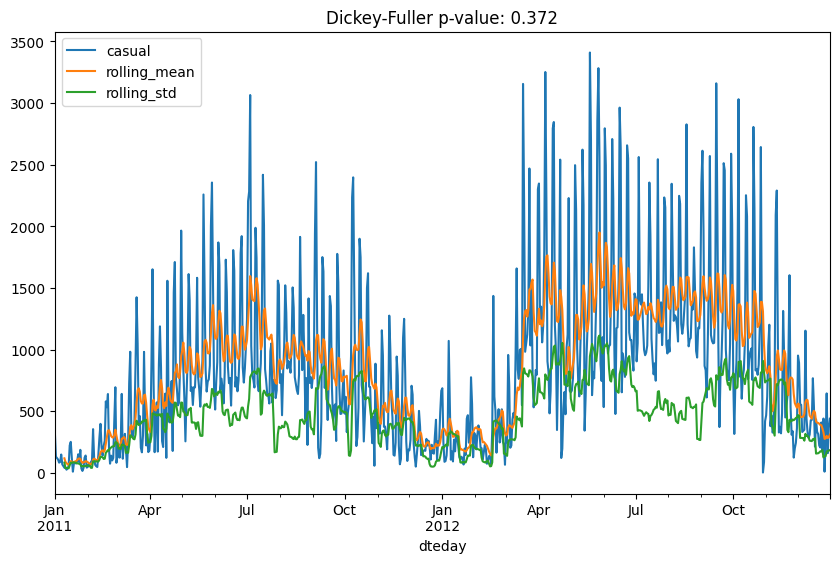

In [117]:
test_stationarity(daily_rides['registered'], figsize=(10, 6))
test_stationarity(daily_rides['casual'], figsize=(10, 6))

#### A common way to detrend a time series and make it stationary is to `subtract either its rolling mean` or its last value, or to `decompose it into a component that will contain its trend, seasonality, and residual components.`

In [118]:
# subtract rolling mean
registered = daily_rides["registered"]
registered_ma = registered.rolling(10).mean()
registered_ma_diff = registered - registered_ma  # Subtracting the Registered Rides from the Registered Rrolling Mean.
registered_ma_diff.dropna(inplace=True)  # dropping the null values

# Doing the same thing for Casual Rides
casual = daily_rides["casual"]
casual_ma = casual.rolling(10).mean()
casual_ma_diff = casual - casual_ma
casual_ma_diff.dropna(inplace=True)

- Now our Data is Stationary, So we can go on with our Model Creation Process.

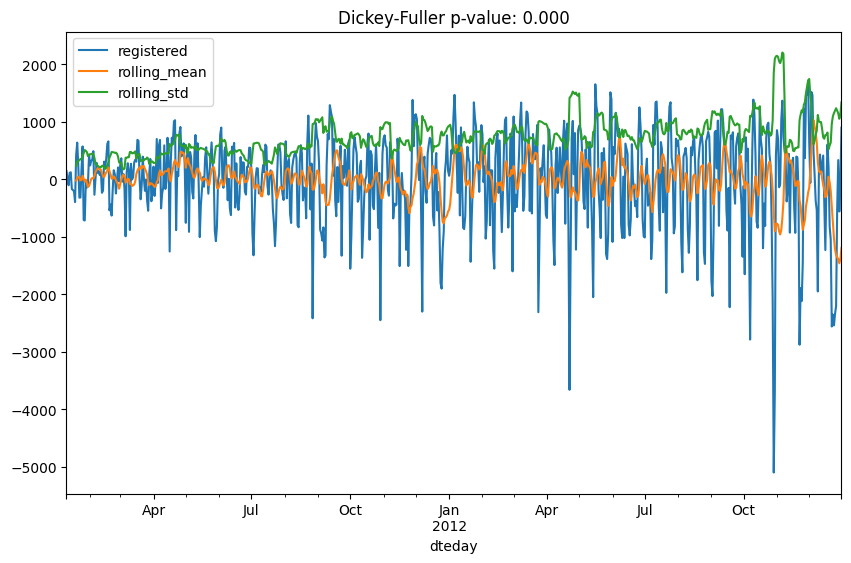

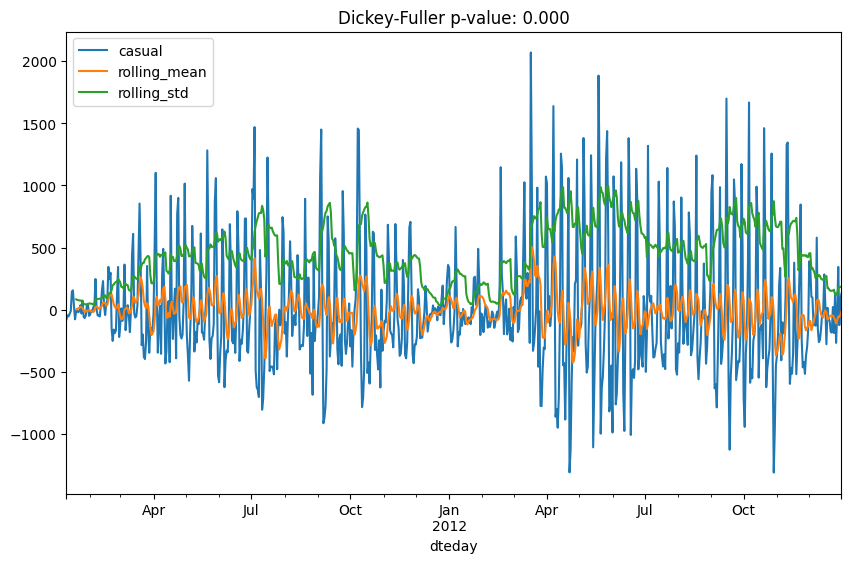

In [119]:
# Testing the Stationarity Again
test_stationarity(registered_ma_diff, figsize=(10, 6))
test_stationarity(casual_ma_diff, figsize=(10, 6))

### ARIMA Models
- Autoregressive Integrated Moving Average (ARIMA) models are a class of 
statistical models that try to explain the behavior of a time series using its own past 
values.
- ACF and PACF are, in general, used to determine the order of integration when 
modeling a time series with an ARIMA model. For each lag, the correlation coefficient 
and level of significance are computed. In general, we aim at an integrated series, in 
which only the first few lags have correlation greater than the level of significance.


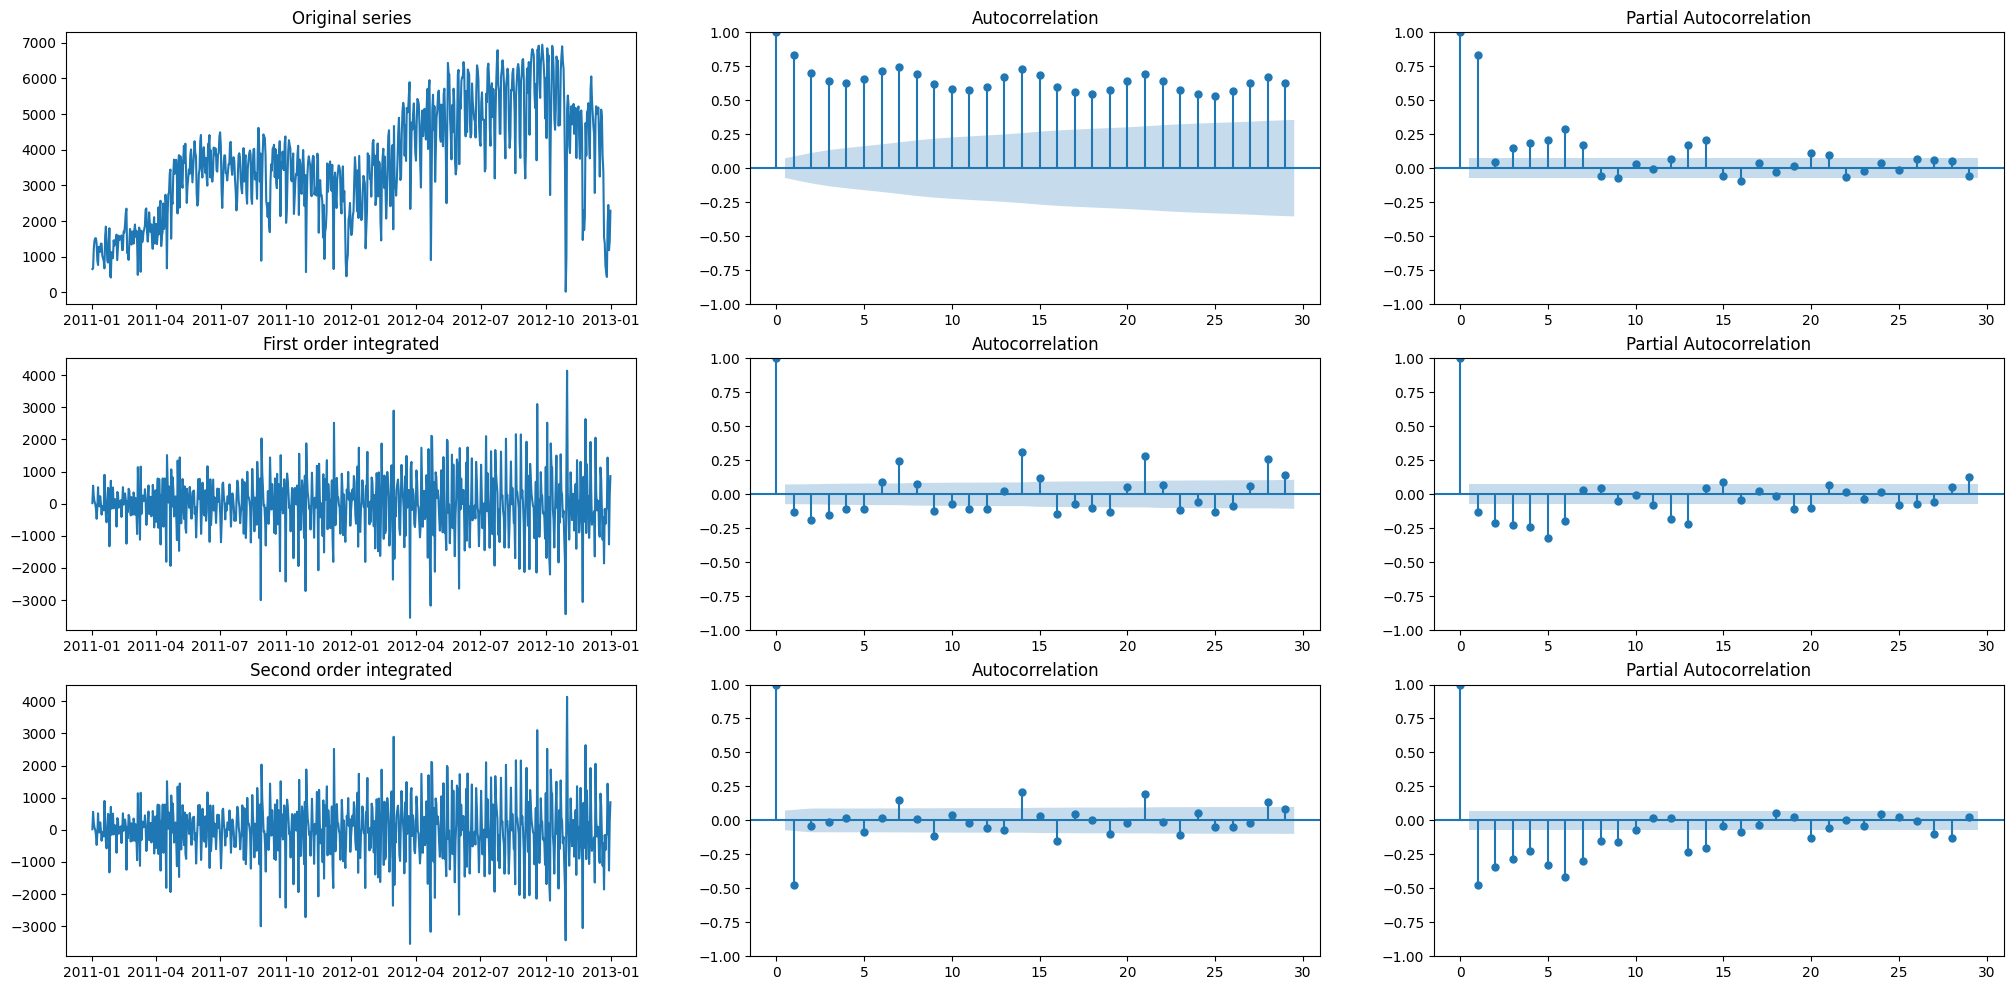

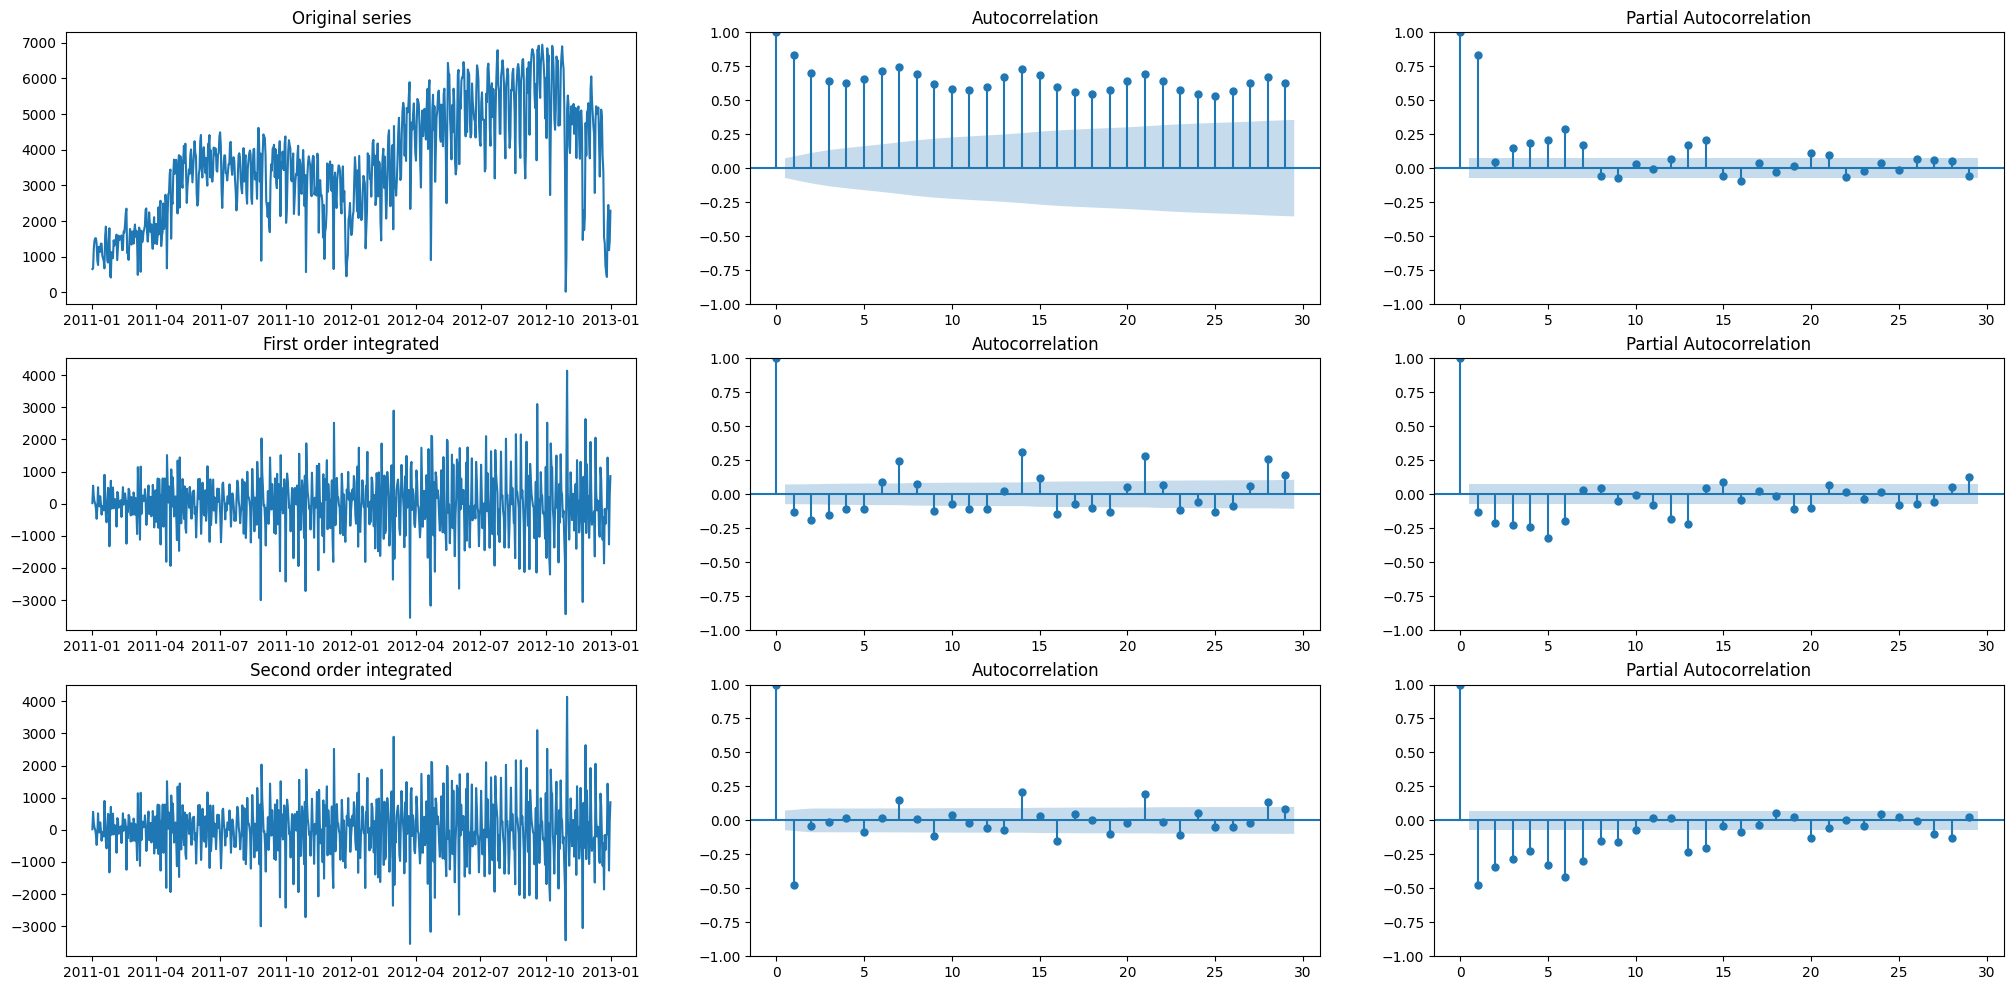

In [120]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 3, figsize=(25, 12))
# plot original series
original = daily_rides["registered"]
axes[0,0].plot(original)
axes[0,0].set_title("Original series")
plot_acf(original, ax=axes[0,1])
plot_pacf(original, ax=axes[0,2])

# plot first order integrated series
first_order_int = original.diff().dropna()
axes[1,0].plot(first_order_int)
axes[1,0].set_title("First order integrated")
plot_acf(first_order_int, ax=axes[1,1])
plot_pacf(first_order_int, ax=axes[1,2])

# plot first order integrated series
second_order_int = first_order_int.diff().dropna()
axes[2,0].plot(first_order_int)
axes[2,0].set_title("Second order integrated")
plot_acf(second_order_int, ax=axes[2,1])
plot_pacf(second_order_int, ax=axes[2,2])


### the original series exhibits several autocorrelation coefficients that are above the threshold. The first order integrated series has only a few, which makes it a good candidate for further modeling (hence, selecting an ARIMA(p,1,q) model). Finally, the second order integrated series present a large negative autocorrelation of lag 1, which, in general, is a sign of too large an order of integration.

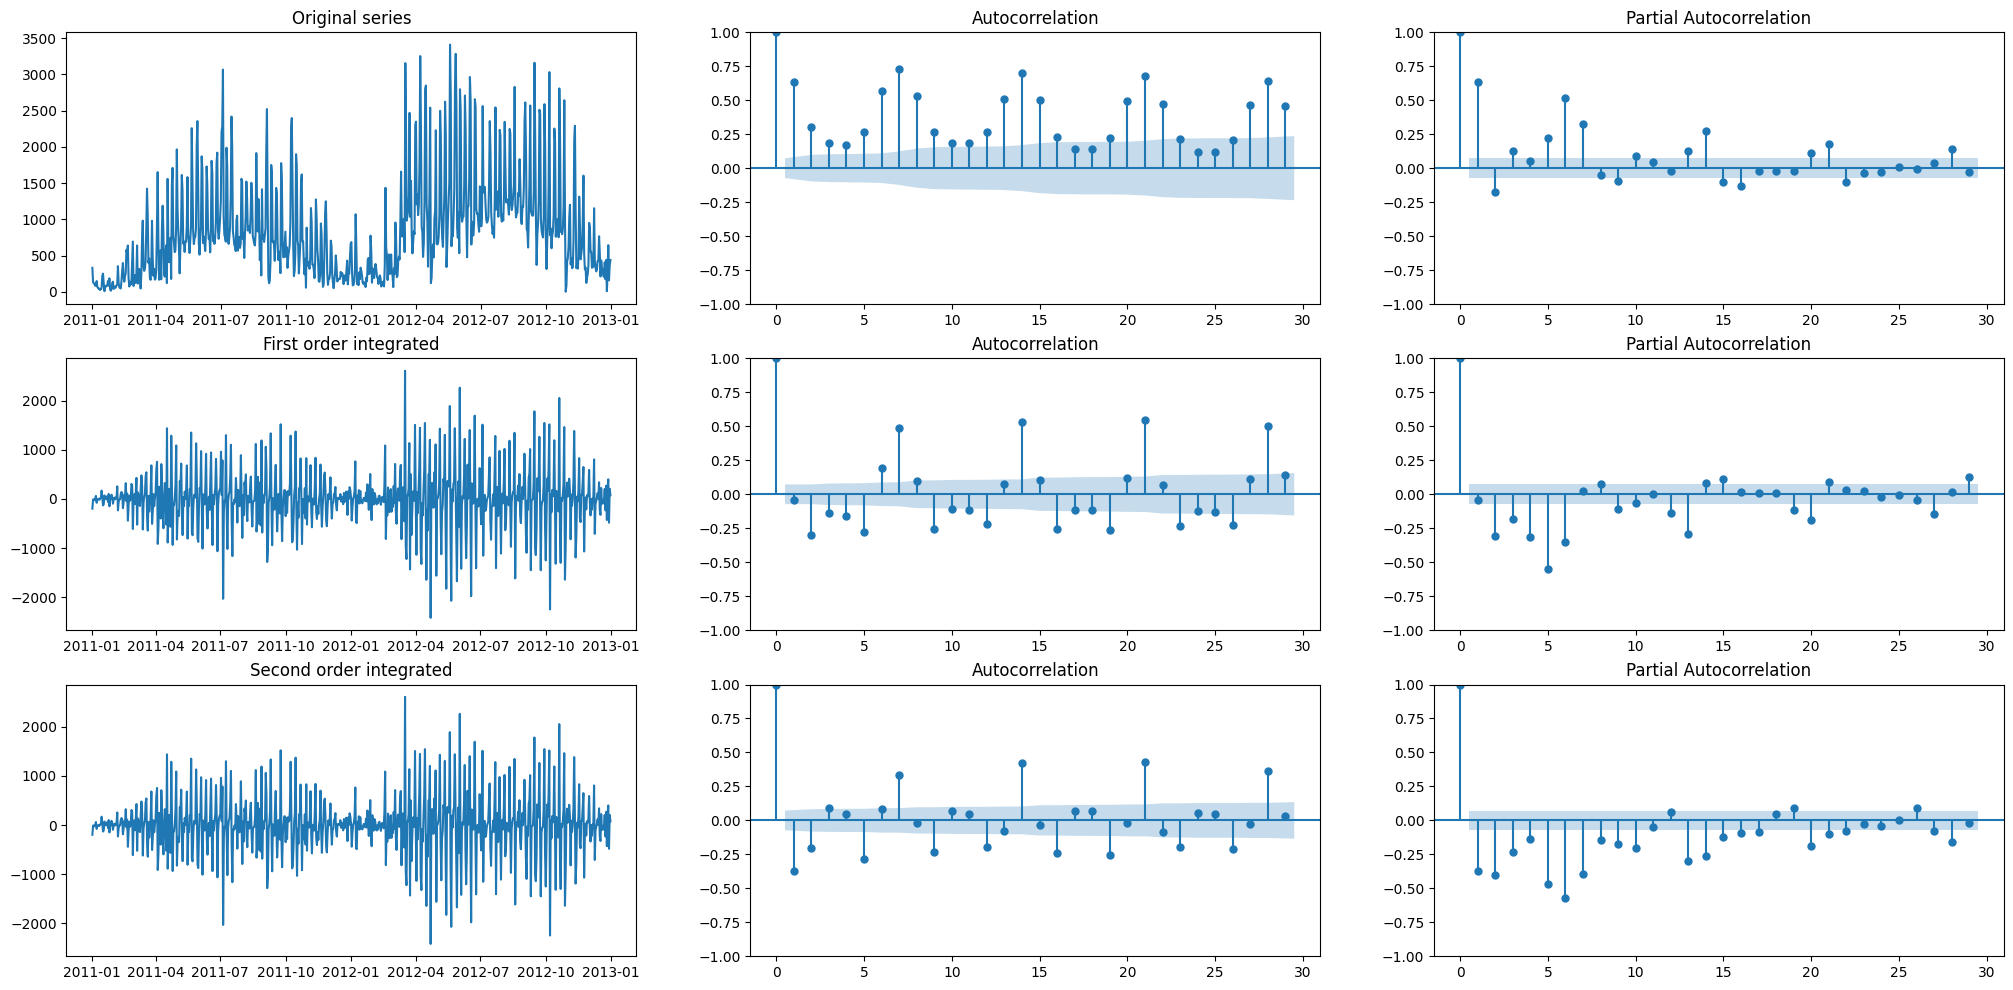

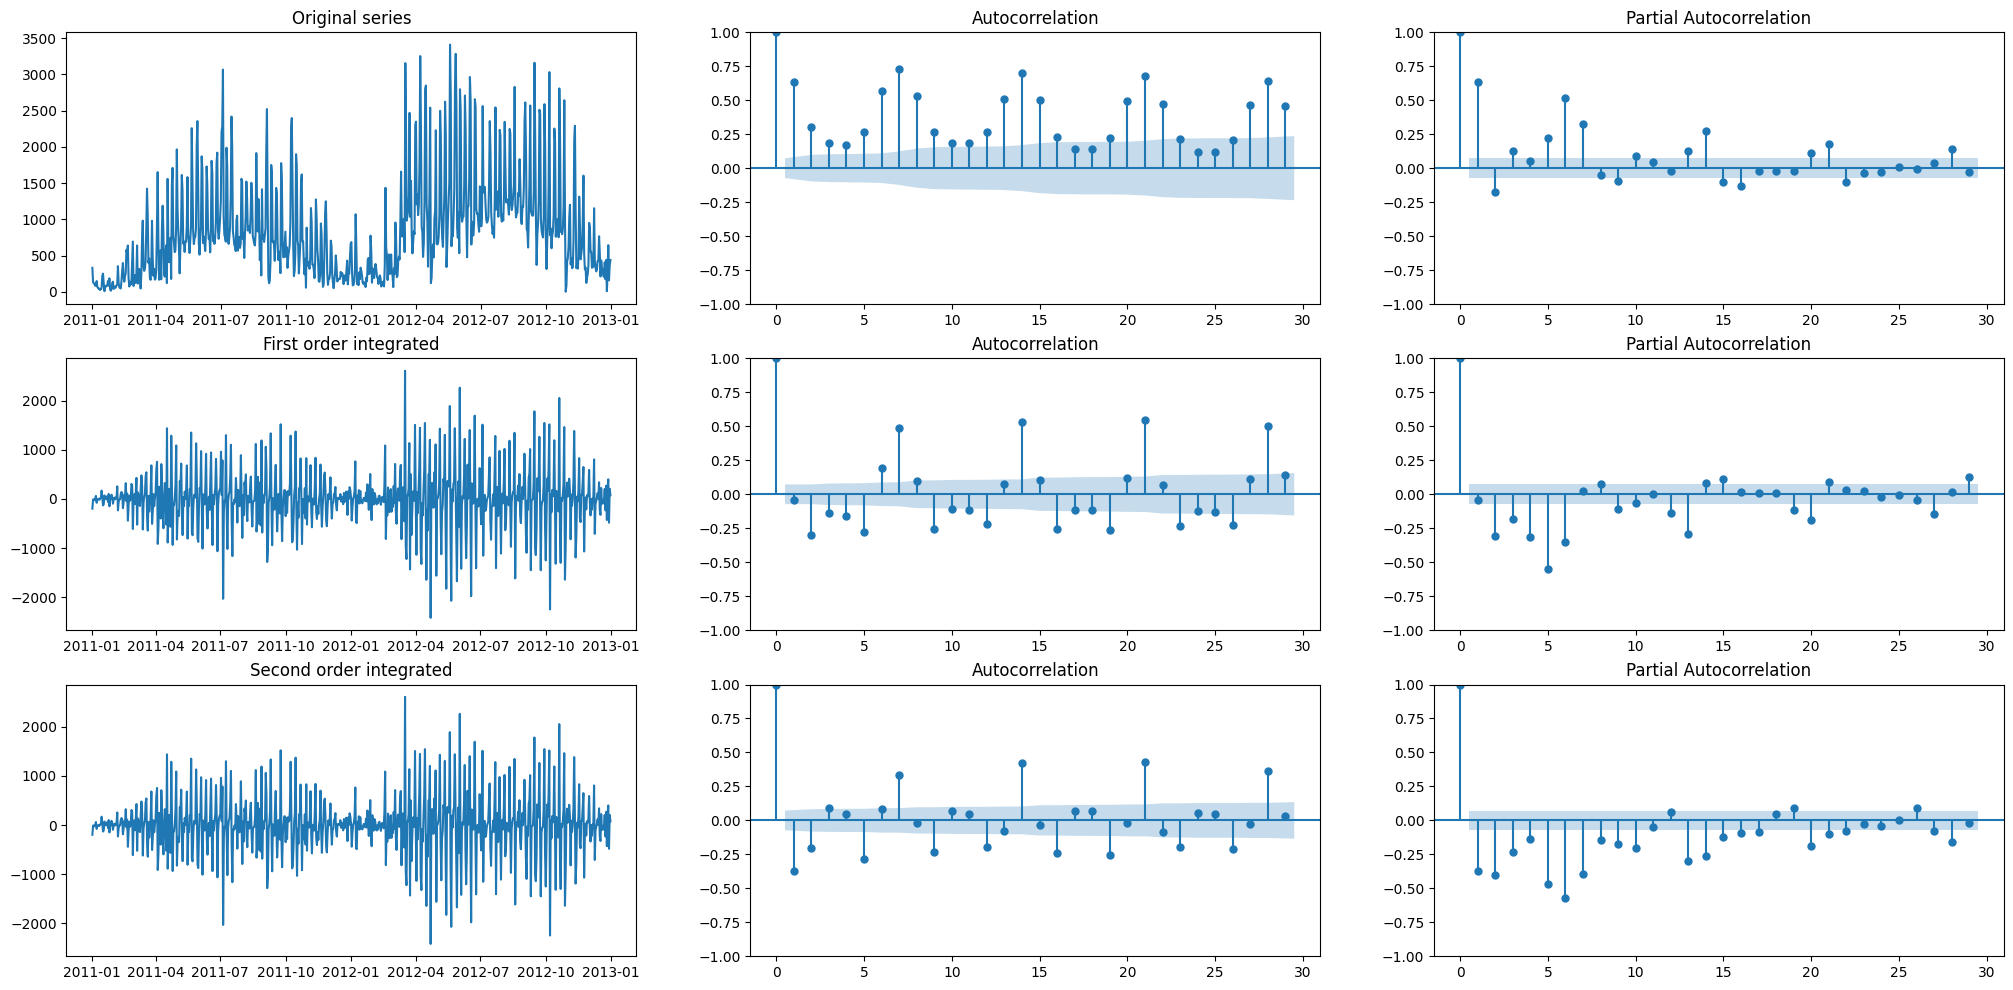

In [121]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 3, figsize=(25, 12))
# plot original series
original = daily_rides["casual"]
axes[0,0].plot(original)
axes[0,0].set_title("Original series")
plot_acf(original, ax=axes[0,1])
plot_pacf(original, ax=axes[0,2])

# plot first order integrated series
first_order_int = original.diff().dropna()
axes[1,0].plot(first_order_int)
axes[1,0].set_title("First order integrated")
plot_acf(first_order_int, ax=axes[1,1])
plot_pacf(first_order_int, ax=axes[1,2])

# plot first order integrated series
second_order_int = first_order_int.diff().dropna()
axes[2,0].plot(first_order_int)
axes[2,0].set_title("Second order integrated")
plot_acf(second_order_int, ax=axes[2,1])
plot_pacf(second_order_int, ax=axes[2,2])


#### Now focus on finding the model parameters and the coefficients for an ARIMA(p,d,q) model, based on the observed registered rides. The general approach is to try different combinations of parameters and chose the one that minimizes certain information criterion, for instance, the `Akaike Information Criterion (AIC)` or the `Bayesian Information Criterion (BIC)`, I will go with Brute Force and I will try Different Combinations of P and Q.

- The Best order values for Casual Rides are `(24, 0, 3)`

In [122]:
p_params = range(0, 33, 8)
q_params = range(0, 4, 1)
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(casual, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(casual, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.15 seconds.
Trained ARIMA (0, 0, 1) in 0.17 seconds.
Trained ARIMA (0, 0, 2) in 0.28 seconds.
Trained ARIMA (0, 0, 3) in 0.43 seconds.
Trained ARIMA (8, 0, 0) in 0.55 seconds.
Trained ARIMA (8, 0, 1) in 1.96 seconds.
Trained ARIMA (8, 0, 2) in 2.76 seconds.
Trained ARIMA (8, 0, 3) in 2.64 seconds.
Trained ARIMA (16, 0, 0) in 3.55 seconds.
Trained ARIMA (16, 0, 1) in 7.91 seconds.
Trained ARIMA (16, 0, 2) in 8.3 seconds.
Trained ARIMA (16, 0, 3) in 8.84 seconds.
Trained ARIMA (24, 0, 0) in 12.57 seconds.
Trained ARIMA (24, 0, 1) in 14.83 seconds.
Trained ARIMA (24, 0, 2) in 21.73 seconds.
Trained ARIMA (24, 0, 3) in 18.85 seconds.
Trained ARIMA (32, 0, 0) in 32.11 seconds.
Trained ARIMA (32, 0, 1) in 47.18 seconds.
Trained ARIMA (32, 0, 2) in 44.62 seconds.
Trained ARIMA (32, 0, 3) in 37.52 seconds.

{0: [520.810335110447, 400.63462985011, 377.24749084835497, 372.94854898067524], 8: [278.2408614644768, 277.98908301280767, 275.78810744923334, 267.288776456940

In [123]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24,32
0,520.8103,278.2409,255.9435,246.5512,247.2165
1,400.6346,277.9891,256.0115,246.5559,246.9211
2,377.2475,275.7881,255.9150,246.4986,246.9592
3,372.9485,267.2888,257.0334,246.6234,247.0210


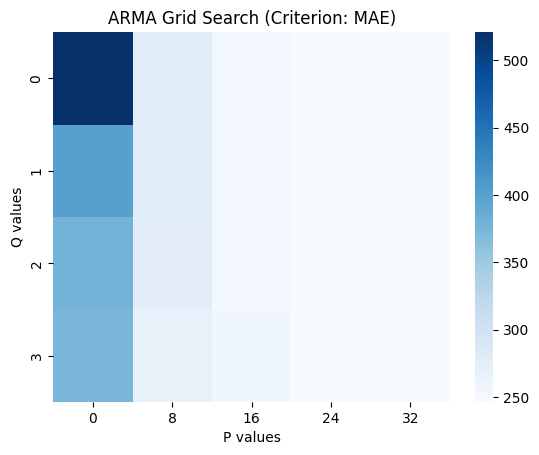

In [124]:
sns.heatmap(mae_df, cmap='Blues')
plt.xlabel('P values')
plt.ylabel('Q values')
plt.title('ARMA Grid Search (Criterion: MAE)');

In [139]:
casual_model = ARIMA(casual, order=(24, 0, 3)).fit()

casual_pred = casual_model.predict()

In [140]:
test_mae = mean_absolute_error(casual, casual_pred)
print("Test MAE for Casual Rides:", round(test_mae, 2))

Test MAE for Casual Rides: 246.62


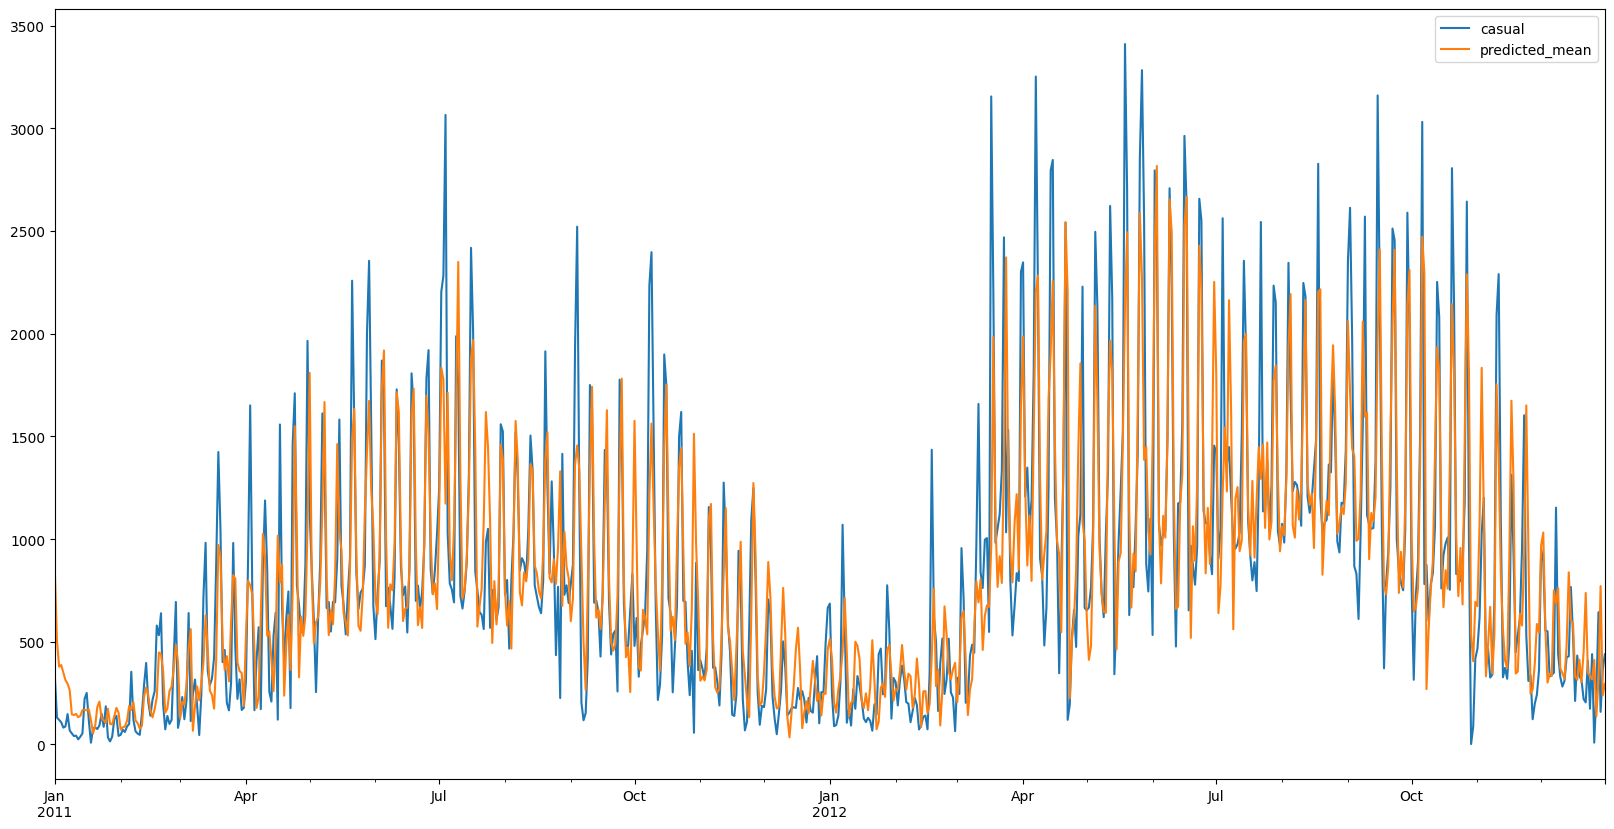

In [141]:
plot_data = pd.concat([casual, casual_pred], axis=1)
plot_data.plot(figsize=(20, 10));

- The best Order values for Registered Rides are `(32, 0, 3)`

In [127]:
p_params = range(0, 33, 8)
q_params = range(0, 4, 1)
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(registered, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(registered, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.18 seconds.
Trained ARIMA (0, 0, 1) in 0.17 seconds.
Trained ARIMA (0, 0, 2) in 0.29 seconds.
Trained ARIMA (0, 0, 3) in 0.47 seconds.
Trained ARIMA (8, 0, 0) in 0.41 seconds.
Trained ARIMA (8, 0, 1) in 1.6 seconds.
Trained ARIMA (8, 0, 2) in 2.79 seconds.
Trained ARIMA (8, 0, 3) in 2.82 seconds.
Trained ARIMA (16, 0, 0) in 2.82 seconds.
Trained ARIMA (16, 0, 1) in 3.88 seconds.
Trained ARIMA (16, 0, 2) in 7.26 seconds.
Trained ARIMA (16, 0, 3) in 6.99 seconds.
Trained ARIMA (24, 0, 0) in 6.54 seconds.
Trained ARIMA (24, 0, 1) in 15.97 seconds.
Trained ARIMA (24, 0, 2) in 12.63 seconds.
Trained ARIMA (24, 0, 3) in 17.64 seconds.
Trained ARIMA (32, 0, 0) in 24.85 seconds.
Trained ARIMA (32, 0, 1) in 42.12 seconds.
Trained ARIMA (32, 0, 2) in 36.06 seconds.
Trained ARIMA (32, 0, 3) in 37.74 seconds.

{0: [1263.7229566394496, 896.5755717911015, 767.4092786740614, 740.1373358335316], 8: [561.0463461431835, 560.4684943981637, 545.0422738839817, 538.7925719352178

In [128]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24,32
0,1263.7230,561.0463,525.0256,513.7058,505.7593
1,896.5756,560.4685,525.7050,513.5946,505.6281
2,767.4093,545.0423,520.9913,513.6162,505.3588
3,740.1373,538.7926,522.8198,515.9178,499.9785


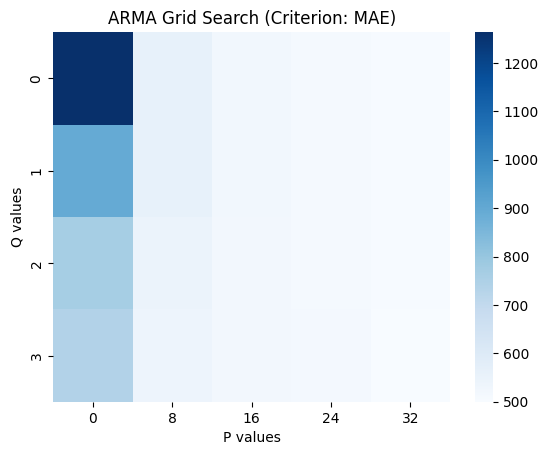

In [129]:
sns.heatmap(mae_df, cmap='Blues')
plt.xlabel('P values')
plt.ylabel('Q values')
plt.title('ARMA Grid Search (Criterion: MAE)');

In [134]:
registered_model = ARIMA(registered, order=(32, 0, 3)).fit()

registered_pred = registered_model.predict()

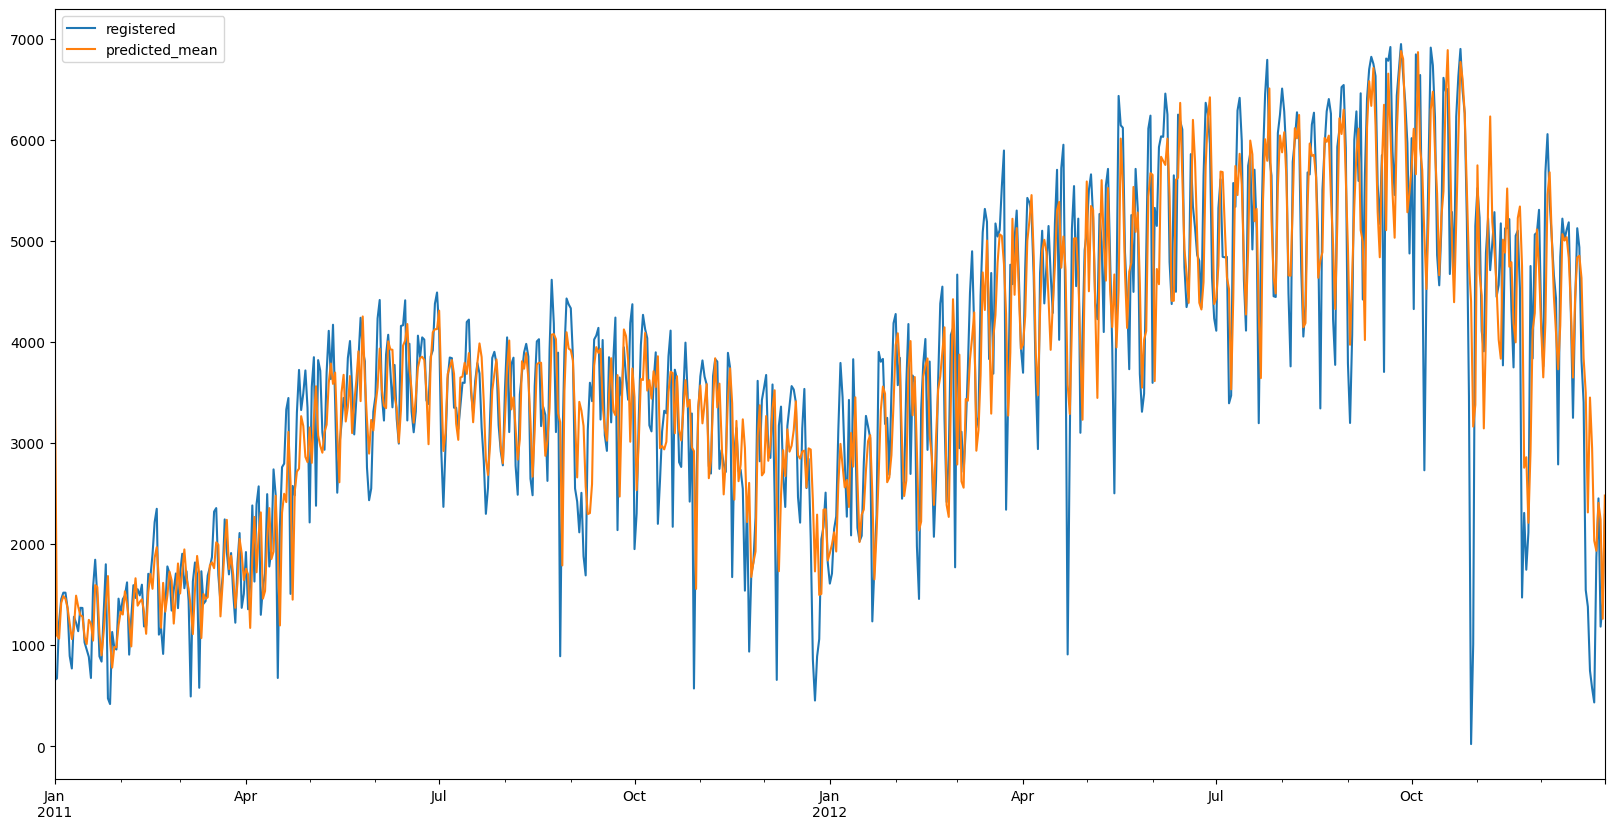

In [135]:
plot_data = pd.concat([registered, registered_pred], axis=1)
plot_data.plot(figsize=(20, 10));

In [136]:
test_mae = mean_absolute_error(registered, registered_pred)
print("Test MAE for Registered Rides:", round(test_mae, 2))

Test MAE for Registered Rides: 499.98
